This notebook should be used to debug, improve or test the log visualization maker.

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 60

In [3]:
#utils.py is where all our custom functions live is we set an autoreload on it.
%aimport utils 
from utils import *
%aimport viz_utils 
from viz_utils import *

# Loading the data

In [4]:
df_all = pd.read_excel('all data v3.xlsx', 'iLab data.txt', index_col=None, na_values=['NA'])

## Preparing a test sample
Let's first use a particular session as a test case. We extract only the data relevant to that case

In [5]:
df_test = prepare_session(df_all,'L-2567b17a:120eda25685:-8000')
df_gaps = prepare_session(df_all,'L-10f11766:120ecd4f63a:-8000')

# Plotting the data

### Session with gap counting

utils.py:155: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return zip(df[df[column].str.contains(action,na=False)]['Time_seconds'],df[df[column].str.contains(action,na=False)]['Duration'])


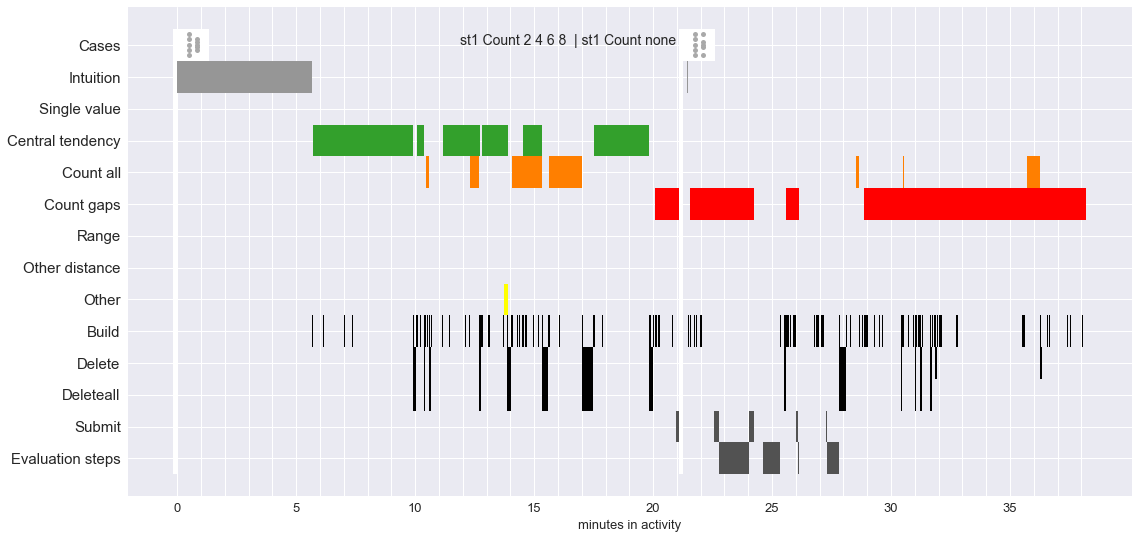

In [6]:
%aimport viz_utils 
plot(df_gaps,to_plot,colors, column_to_use, function_to_use)

### Session with range and extrapolated range

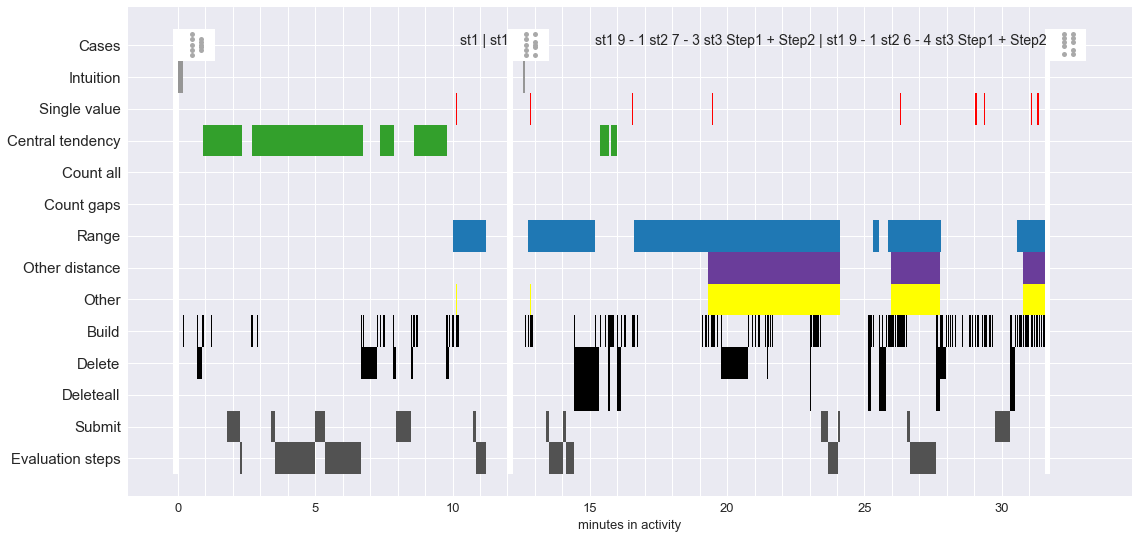

In [7]:
%aimport viz_utils 
plot(df_test,to_plot,colors, column_to_use, function_to_use)

# Testing

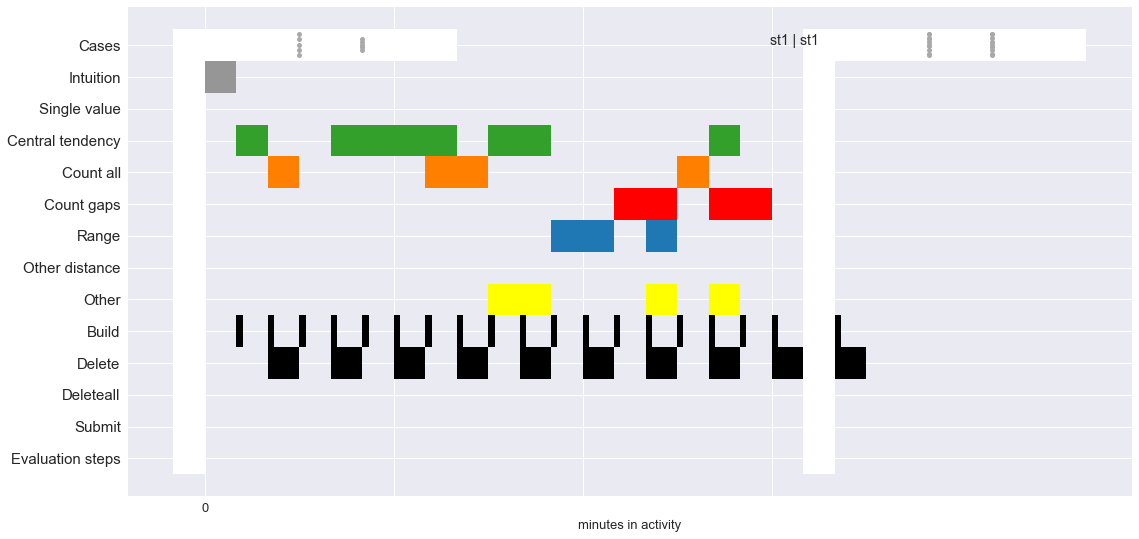

In [8]:
df_test2 = pd.read_excel('all_method_tester.xlsx', 'Sheet1', index_col=None, na_values=['NA'])

%autoreload
REGEX_SINGLE_VALUE_FIRST = "st\d \d(?:$|(?:\sst)|(?:\s[\-\+x/]\s[A-Z]))"
REGEX_SINGLE_VALUE_SECOND = "st\d [A-Z][\sa-z]+ [\-\+x/] \d(?:$|(?:\s?st))"

def single_value_usage(df):
    usage= []
    method1 = action_usage(df,'Cleaned method 1',REGEX_SINGLE_VALUE_FIRST)
    usage.extend(action_usage(df,'Cleaned method 2',REGEX_SINGLE_VALUE_FIRST))
    usage.extend(action_usage(df,'Cleaned method 1',REGEX_SINGLE_VALUE_SECOND))
    usage.extend(action_usage(df,'Cleaned method 2',REGEX_SINGLE_VALUE_SECOND))
    return clean_coords(usage)

single_value_usage(df_test2)

%aimport viz_utils 
plot(df_test2,to_plot,colors, column_to_use, function_to_use)

### TO DO
#### Ordered in some kind of general priority (in terms of need of feedback and desired feature)
1. Fix other Other category
* fix visual component of build, delete and submit
* clean visual - embellish
* run on all 9 student pairs

#### What can invention be? (Rename as Other)  - Two options:
1. Lots of differernt pre-set possibilities 
    * Anytime they use addition within a step?
    * Anytime they use multiplication
    * Use a combination of central tendency
    * Use a combination of methods (range and mean)
2. Any method that isn't other methods
    * after removing chuncks that fit our methods, is there anything left?
    * or
    * anything that has more than two steps subtracting time coords of methods.

#### Done
* central tendency (average median sum) - add "choose 2 4 5 7" in regex
* Show the method that eventually “cracks” the cases (succeeds to solve and move on)


#### Testing
What works
* Central al works
* Combo of central all works
* COunt gaps (even one gap) works. It doesn't light up when counting case numbers
* Combo of count gaps and Average
* Combo of count gaps and range

What doesn't
* Central choose...
* st1 5 st2 9 - 1 lights up range (good) but not single value
* Combo count al + distance doesn't light up distnace nor Other

# Export dataframe

In [9]:
# #Using the example used for sketch.
# def export_df(df,name):
#     select_df = df[["Session Id","Selection","Feedback Text","Cleaned method 1","Cleaned method 2","cases","Time_seconds","Timeshifted","Duration"]]
#     writer = pd.ExcelWriter(name+'.xlsx')
#     select_df.to_excel(writer,'Sheet1')
#     writer.save()
#
# export_df(df_gaps,'gaps')
# export_df(df_test,'test')